In [2]:
!python --version

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sb
import os
import h5py
import dask.dataframe as dd
import dask
import tsfresh
import plotly 
plotly.tools.set_credentials_file(username='ptolmachev', api_key='Fs5sBFAg7YuBn52rzy6n')

def downsample(df, take_every):
    return df.loc[::take_every]

def nice_plot(series):
    fig = plt.figure(figsize = (16,4))
    plt.grid(True)
    try:
        plt.plot(series.compute().tolist(), 'r-',linewidth = 2, alpha = 0.7)
    except:
        plt.plot(series.tolist(), 'r-',linewidth = 2, alpha = 0.7)
    plt.show()

Python 3.7.2


In [4]:
pd.set_option('precision', 15)


In [ ]:
df = pd.read_csv('./LANL-Earthquake-Prediction/sample.csv', index_col = False)
print(df.info(memory_usage='deep'))
df.columns = ['s', 'y']
df['s'] = df['s'].astype(np.int16)
print(df.info(memory_usage='deep'))
df.to_csv('./LANL-Earthquake-Prediction/sample_downcasted.csv',index=False)

df = pd.read_csv('./LANL-Earthquake-Prediction/sample_downcasted.csv', index_col = False)
print(type(df['s'][0]))
print(df.info(memory_usage='deep'))


In [ ]:
df = pd.read_csv('./LANL-Earthquake-Prediction/train_downcasted.csv', index_col = False)
print(df.info(memory_usage='deep'))

In [ ]:
print(df.info(memory_usage='deep'))
s = df['acoustic_data'].astype('int16')
df['acoustic_data'] = s
y = df['time_to_failure'].astype('float32')
df['time_to_failure'] = y
print(df.info(memory_usage='deep'))
df.head()
# ser = pd.Series([1, 2], dtype='int32')
# print(df.info(memory_usage='deep'))

# Analysis

In [ ]:
%%time
ddf = dd.read_csv('./LANL-Earthquake-Prediction/three_earthquakes.csv')
ddf.head()
ddf.columns = ['s','y']
print("min s = {}".format(ddf.s.min().compute()))
print("max s = {}".format(ddf.s.max().compute()))
print("mean s = {}".format(ddf.s.mean().compute()))

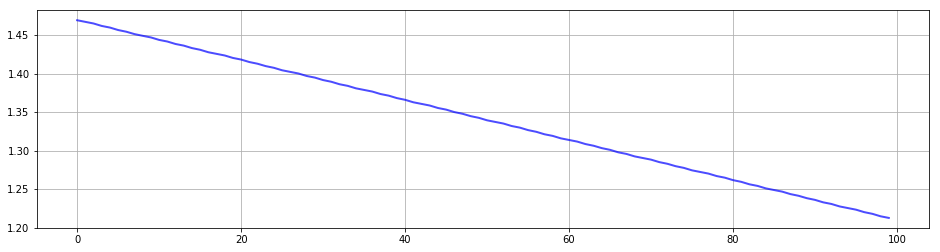

In [5]:

    
#taking every 1000 of samples
df_down = downsample(ddf, 10000).compute()
# nice_plot(ddf.s)
nice_plot(df_down.y)

In [14]:
%%time
ddfs = []
for i in range(3):
    ddfs.append(dd.read_csv('./LANL-Earthquake-Prediction/EQ_'+str(i+1)+'.csv'))
#     print(ddfs[-1].s.pow(2).mean().compute())

CPU times: user 52.9 ms, sys: 26 µs, total: 52.9 ms
Wall time: 51.3 ms


In [15]:
import plotly
import plotly.graph_objs as go

data = [go.Scatter(y=downsample(ddfs[i], 10).compute().s+i*1000, opacity = 0.7) for i in range(3)]
layout = dict(
    title='Three Earthquakes'
)

fig = dict(data=data, layout=layout)
plotly.offline.plot(fig, filename = "Signals before the earthquakes.html", auto_open=True)

'file:///home/pavel/Documents/0Research/Projects/Kaggle/Signals before the earthquakes.html'

In [ ]:
ddfs_downsampled_10 =  [downsample(ddfs[i], 100).compute() for i in range(3)]

In [ ]:
# # Mean and std over windows

data = [go.Scatter(y=windowed_operation(ddfs_downsampled_10[i].s, 100, "np.std")+i*100, opacity = 0.7) for i in range(3)]
layout = dict(
    title='Three Earthquakes (std)'
)

fig = dict(data=data, layout=layout)
plotly.offline.plot(fig, filename = "Signals before the earthquakes.html", auto_open=True)


# DASK featurization

In [2]:
ddf = (dd.read_csv('./LANL-Earthquake-Prediction/sample.csv'))
ddf.columns = ["s","y"]

In [3]:
# FUNCTIONS FOR COMPUTING FEATURES

def ema_sum(x, alpha = 0.9): #custom made function
    coeff = np.array([alpha**i for i in range(len(x))])*(1-alpha)/(1-alpha**(len(x)))
    return np.sum([x*c for x,c in zip(x,coeff)]).astype(np.float16)


In [3]:
#test
param = [{'f_agg':'std', 'maxlag' : 10}]
print(tsfresh.feature_extraction.feature_calculators.agg_autocorrelation(ddf.s, param)[0][-1])
# param = [{"attr": 'pvalue'}]
# print(tsfresh.feature_extraction.feature_calculators.augmented_dickey_fuller(ddf.s, param)[0][-1])
param = 10
print(tsfresh.feature_extraction.feature_calculators.c3(ddf.s, param))

0.47346280029379895
-39.06544230884618


In [15]:
%%time
# MAIN FUNCTION FOR COMPUTING STATISTICS
def windowed_operation(signal, window, stride, function, args):
    '''
    get time series as an input and outputs dask dataseries
    '''
    if function in ["max",'min','mean','kurt','skew','sum','std']: #generally can be computed faster
        return eval("signal.rolling(window = window, min_periods = 1, center = False)." + function + "()" )
    else:
        try: # if there is a corresponding function in tsfresh:
            if function in args.keys(): # if this function requires additional  arguments
                return signal.rolling(window = window, min_periods = 1, center = False)\
                        .apply(eval("tsfresh.feature_extraction.feature_calculators."+function),\
                        args = [*args[function].values()])
            else:
                return signal.rolling(window = window, min_periods = 1, center = False)\
                        .apply(eval("tsfresh.feature_extraction.feature_calculators."+function))
            
        except: #if it is a custom made function
            if function in args.keys(): # if this function requires additional  arguments
                return signal.rolling(window = window, min_periods = 1, center = False)\
                    .apply(eval(function), args = [*args[function].values()])
            else:
                return signal.rolling(window = window, min_periods = 1, center = False)\
                    .apply(eval(function))


ddf_extended = ddf.copy()
features = ['']
# features = ['abs_energy', 'count_above_mean','c3','variance_larger_than_standard_deviation','variance'] #2 min 50 sec
# features = ['time_reversal_asymmetry_statistic','ratio_value_number_to_time_series_length']   # 1 min 20 sec  
# features =  ['time_reversal_asymmetry_statistic'] #,'ratio_value_number_to_time_series_length'] #  31 sec
# features =  ['ratio_value_number_to_time_series_length'] # 51 sec
# features = ['ratio_beyond_r_sigma','number_peaks','number_crossing_m','mean_second_derivative_central'] #4min 12s
# features = ['mean_abs_change','longest_strike_below_mean','longest_strike_above_mean'] #35min 21s
# features = ['last_location_of_minimum','last_location_of_maximum'] # 19 sec
# features = ['mean_abs_change'] # 35 sec
# features = ['longest_strike_below_mean'] # 20min 6s
features = ['quantile'] # 20min 6s
#"min",'max','sum','mean','std','kurt','skew','ema_sum',
args = {'ema_sum' : {'alpha' : 0.95},
        'c3' : {'param' : 10},
        'time_reversal_asymmetry_statistic' : {'lag' : 10},
        'ratio_beyond_r_sigma' : {'r' : 2.0},
        'quantile' : {'q' : 75},
        'number_peaks' : {'n' : 3},
        'number_crossing_m' : {'m' : 0}
       } # they have to go in the same order as in the fucntion!!
# spkt_welch_density - returns list of coefficients
# 'symmetry_looking' : {'r' : 0.5}
# partial_autocorrelation
# number_cwt_peaks
# sample_entropy - fucking too time-consuming
# 'quantile','min_change' - not defined?
windows = [10,100,1000]
for feature in features:
    for window in windows:
        ddf_extended["s_" + feature+"_" + str(window)] = windowed_operation(ddf.s,window,feature,args)

TypeError: rolling() got an unexpected keyword argument 'step'

In [13]:
%%time
ddf_extended.head(200)

CPU times: user 20min 12s, sys: 8.03 s, total: 20min 20s
Wall time: 20min 6s


,s,y,s_longest_strike_below_mean_10,s_longest_strike_below_mean_100,s_longest_strike_below_mean_1000
0,12,1.4691,1.0,1.0,1.0
1,6,1.4691,1.0,1.0,1.0
2,8,1.4691,2.0,2.0,2.0
3,5,1.4691,1.0,1.0,1.0
4,8,1.4691,1.0,1.0,1.0
5,8,1.4691,1.0,1.0,1.0
6,9,1.4691,5.0,5.0,5.0
7,7,1.4691,1.0,1.0,1.0
8,-5,1.4691,1.0,1.0,1.0
9,3,1.4691,2.0,2.0,2.0


#TO DO: write your own function which accepts dask/pandas array and applies operation to some window with the specified stride

In [2]:
import pandas as pd
import dask.dataframe as dd
import tsfresh
import numpy as np
from tqdm import tqdm_notebook as tqdm
ddf = (dd.read_csv('./LANL-Earthquake-Prediction/sample.csv'))
ddf.columns = ["s","y"]
# [1,2,3|,4,5|,6,7|,8,9|,10] *|

In [125]:
%%time
def rolling_window(series, window_size, stride, function, params = None):
    len_series = len(series)
    
    if "dask" in str(type(series)):
        modifier = ".compute()"
    else:
        modifier = ""
        
    #various expressions for various functions
    if function in ["max",'min','mean','std','skew','kurt']:
        expression = ("window."+function+"()" + modifier)
    else:
        if params is None:
            expression = ("window.apply(" + function + ")" + modifier)
        else:
            expression = ("window.apply(" + function + ", params = params)" + modifier)
            
    num_iter = int(np.ceil((len_series-window_size)/stride)+1)
    res = np.empty(num_iter, dtype = np.float16)
    print("the expression used: {}".format(expression))
    for i in range(num_iter):
        window = series.loc[i*stride:min(i*stride + window_size, len_series)]
        #the last window may have lesser length
        res[i] = np.float16(eval(expression))
    
    return res
    
series = ddf["s"]
stds = rolling_window(series, 1000, 500,"mean")

the expression used: window.mean().compute()
CPU times: user 6min 27s, sys: 8.53 s, total: 6min 36s
Wall time: 6min 35s


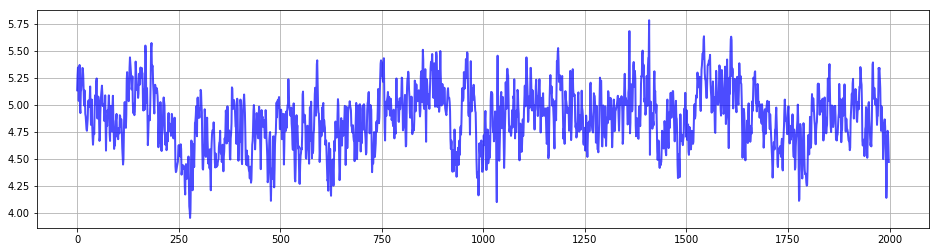

In [126]:
nice_plot(stds)

In [44]:
%%time
ddf = (dd.read_csv('./LANL-Earthquake-Prediction/train.csv'))
ddf.columns = ["s","y"]
series = ddf["s"]
a = np.array(series)

def rolling_window(series, window_size, stride, function, params = None):
    len_series = len(series)
    num_iter = int(np.ceil((len_series-window_size)/stride)+1) 
    
    if params is None:
        kwargs = {}
    else:
        kwargs = params
    
    shape = series.shape[:-1] + (series.shape[-1] - window_size + 1, window_size)
    strides = series.strides + (series.strides[-1],)
    iterator = iter(np.lib.stride_tricks.as_strided(series, shape=shape, strides=strides)[::stride])
    res = np.empty(num_iter, dtype = np.float16)
    
    if hasattr(tsfresh.feature_extraction.feature_calculators, function):
        modifier = "tsfresh.feature_extraction.feature_calculators."
    else:
        modifier = ""

    expression = modifier + function + "(next(iterator), **kwargs)"
    
    for i in range(num_iter):
        try:
            res[i] = np.float(eval(expression))
        except StopIteration:
            return res[:i]
    
    return res

CPU times: user 3min 3s, sys: 34.4 s, total: 3min 37s
Wall time: 4min 12s


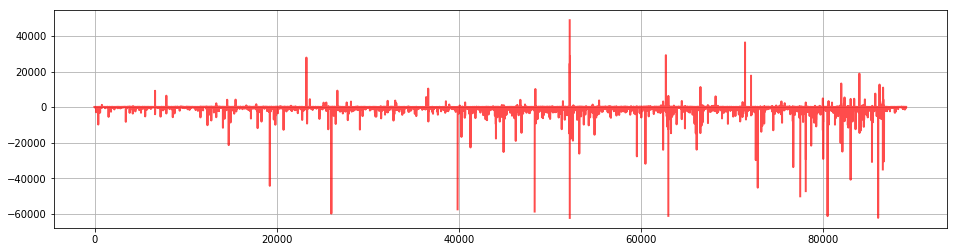

In [26]:
res = rolling_window(a,1000,500,"c3", params = {"lag":10})
nice_plot(res)

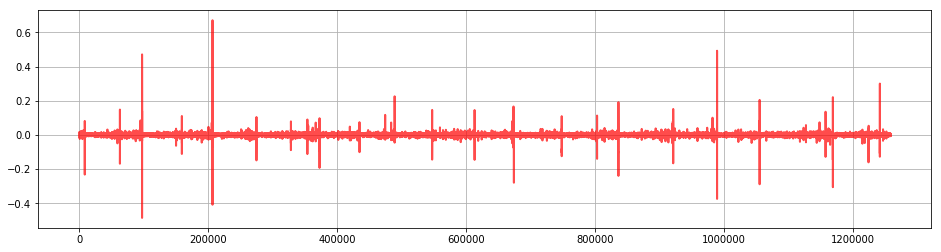

In [45]:
res = rolling_window(a,1000,500,"mean_second_derivative_central")
nice_plot(res)

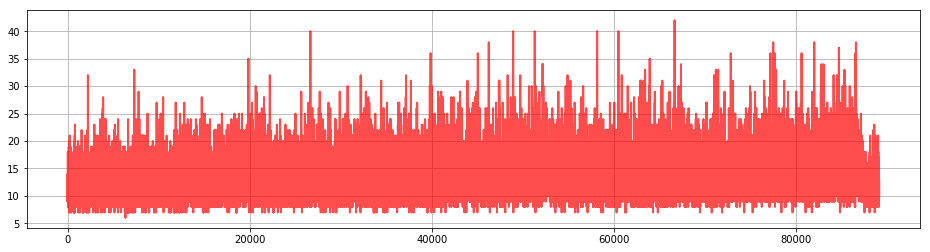

In [24]:
res = rolling_window(a,1000,500,"longest_strike_above_mean")
nice_plot(res)


In [ ]:
%%time 
res = rolling_window(a,1000,500,"quantile",params = {"q" : 0.5})
nice_plot(res)

In [40]:
ddf = pd.read_hdf("./sample.h5")
print(ddf.head())

    s       y
0  12  1.4691
1   6  1.4691
2   8  1.4691
3   5  1.4691
4   8  1.4691


In [ ]:
def calc_data(df, list_of_functions, list_of_params, window_sizes, stride, save_to):
    '''
    Input: pandas array with columns 's' and 'y' 
    ('s' corresponds to time series and 'y' - to the regression label)
    
    saves new pandas dataframe in hdf5 extension to "save_to" location
    where the columns are the calculated over the time series features from the "list_of_function"
    using windows from "window_sizes" and having a spesified stride
    '''
    
    #checks
    if (len(list_of_functions) != len(list_of_params)) or (len(list_of_params) != len(window_sizes)):
        raise ValueError("Parameters \"list_of_functions\", \
        \"list_of_params\" and \"window_sizes\" must have the same lengths!")
    if stride <=0 :
        raise ValueError("The \"stride\" has to be a postivie number!")
    
    try:
        feature_df = pd.read_hdf(save_to) # if there already exists file with features
    except:
        feature_df = pd.DataFrame()
    
    num_features = len(list_of_functions)
    series = np.array(df["s"])
    for i in range(num_features):
        name_of_col = function + "_" + "window"
        if name_of_coll in feature_df:
            pass
        else:
            res = rolling_window(series, window_sizes[i], stride, function, params = list_of_params[i])
            feature_df[name_of_col] = res
        
        
    